# Bayesian Linear Regression Tutorial

This is a tutorial on implementing Bayesian linear regression. We will use methods described in "Pattern Recognition and Machine Learning" by Christopher Bishop on synthetic regression data. 

In this example, we will assume our model has zero mean Gaussian error with a precision $\beta$ and we will use zero mean Gaussian priors on parameters with precision $\alpha$. 

In [1]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
# import Bayesian Linear Regression Class 
from LR import BLR 

Import Regression Data: 

In [2]:
# import data
X = np.genfromtxt('data/features.csv')
Y = np.genfromtxt('data/targets.csv')

# define training and testing data sets
N_samples, N_features = X.shape

# randomly shuffle data set 
randargs = np.random.permutation(N_samples)
X = X[randargs, :]
Y = Y[randargs]

N_train = int(.8*N_samples)

X_train = X[:N_train, :] 
X_test = X[N_train:, :]
Y_train = Y[:N_train]
Y_test = Y[N_train:]

Fit a Bayesian linear regression model and maximize evidence function

In [3]:
blr = BLR(X_train, Y_train, a=.0005, b=.001, max_evidence=True)
print(blr.a)
print(blr.b)

attempting to maximize evidence function
0.0005321800081855187
0.0027958263836325424


Make Predictions on test data 

In [4]:
Y, E = blr.predict(X_test)

Plot Results! 

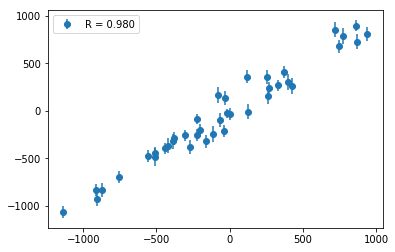

In [6]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y)
plt.errorbar(Y_test, Y, linestyle='none', marker='o', yerr = E.diagonal()**.5, label='R = {:.3f}'.format(r_value))
plt.legend()
plt.show()